In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
from tqdm.notebook import tqdm
import math
import pickle
import gc
import json
import time
# import skimage.metrics
from skimage import metrics

# pytorch stuff
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
# from torchgeometry.losses import dice_loss


# need for AMP
from torch.cuda.amp import autocast
from torch.cuda.amp import GradScaler

In [289]:
from matplotlib.patches import Rectangle

filepath_120 = '/data/public/NANO_dual_energy/20211205_cirs_phantom_kvs/'\
               '120kV/2021-12__Studies/drr/compound_rotations/0_0_0.npy'

with open(filepath_120, 'rb') as f:
    sample_drr_120 = np.load(f)

sample_drr_120 = sample_drr_120 - np.mean(sample_drr_120)
sample_drr_120 /= np.std(sample_drr_120)
sample_drr_120 *= -1
# img = np.pad(sample_drr_120, ((35, 35), (0, 0)), mode='edge')


In [281]:
# basic unet with batch normalization
f_size = 7
padding = (f_size//2, f_size//2)
chs = [32, 64, 128, 256, 512] 

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels, out_channels, f_size, padding=padding)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, f_size, padding=padding)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
#         x = self.conv1(x.double())
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

    
class UNet(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        # pooling
        self.pool = nn.MaxPool2d(2,2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # ENCODER
        self.conv00 = ConvBlock(1, 32)
        self.conv10 = ConvBlock(32, 64)
        self.conv20 = ConvBlock(64, 128)
        self.conv30 = ConvBlock(128, 256)
        self.conv40 = ConvBlock(256, 512)
        
        # DECODER
        self.upconv31 = nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1, output_padding=1)
        self.conv31 = ConvBlock(2*256, 256)
        self.upconv22 = nn.ConvTranspose2d(256, 128, 3, stride=2)
        self.conv22 = ConvBlock(2*128, 128)
        self.upconv13 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1)
        self.conv13 = ConvBlock(2*64, 64)
        self.upconv04 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1)
        self.conv04 = ConvBlock(2*32, 32)
        
        # final layers
#         self.final04 = nn.Conv2d(32, 2, 1)
        self.final04 = nn.Conv2d(32, 1, 1)
#         self.sigmoid_layer = nn.Sigmoid()
         
    def forward(self, x):
        
        # Encoder Path
        x00 = self.conv00(x)
        x10 = self.conv10(self.pool(x00))
        x20 = self.conv20(self.pool(x10))
        x30 = self.conv30(self.pool(x20))
        x40 = self.conv40(self.pool(x30))
        
        
        # Up-sampling 
        x31 = self.upconv31(x40)
#         print(x30.shape, x31.shape)
        x31 = self.conv31(torch.cat((x30,x31), dim=1))
        x22 = self.upconv22(x31)
        x22 = self.conv22(torch.cat((x20,x22),dim=1))
        x13 = self.upconv13(x22)
        x13 = self.conv13(torch.cat((x10,x13),dim=1))
        x04 = self.upconv04(x13)
        x04 = self.conv04(torch.cat((x00,x04),dim=1))
        
        # Outputs
        x04 = self.final04(x04)

        
        return x04

In [282]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
generator_model = UNet().to(device)

In [284]:
soft_model_path = '/home/manwatkarc/DualEnergy_Synthetic_Energy/src/evaluation/logs/06_Mar_22-02:02:58/generator_model_soft(06_Mar_22-02:02:58).pt'
generator_model.load_state_dict(torch.load(soft_model_path, map_location="cuda:3"))
# model = torch.load(soft_path, map_location="cuda:3")

<All keys matched successfully>

In [16]:
(260-178)/2

41.0

In [17]:
260-41

219

In [288]:
sample_drr_120.shape

(190, 178)

In [290]:
img = np.pad(sample_drr_120, ((35, 35), (0, 0)), mode='edge')
# img = sample_drr_120[:178]
img.shape

(260, 260)

In [291]:
datapoint = torch.from_numpy(img)
unsqueezed = torch.unsqueeze(datapoint.to(device), 0)
unsqueezed = torch.unsqueeze(unsqueezed, 0)
fake = generator_model(unsqueezed.float())

Text(0.5,1,'Fake Bone')

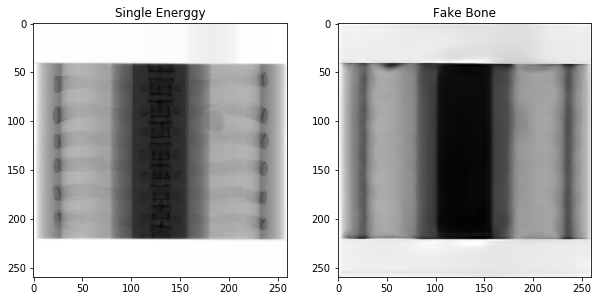

In [292]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(unsqueezed.cpu().detach().numpy()[0][0], cmap='gray')
ax[0].set_title('Single Energgy')
ax[1].imshow(fake.cpu().detach().numpy()[0][0], cmap='gray')
ax[1].set_title('Fake Bone')
# ax[1].imshow(fake.cpu().detach().numpy()[0][0], cmap='gray')
# ax[1].set_title('Fake Soft Tissue')

In [293]:
class DualEnergyDataset:
    def __init__(self,
                 SE_dataroot='/data/public/NANO_dual_energy/20211205_cirs_phantom_kvs/'\
                             '120kV/2021-12__Studies/drr/compound_rotations',
                 bone_dataroot='/data/public/NANO_dual_energy/20211205_cirs_phantom_kvs/'\
                               'DE_subtracted/compund_rotations/bone',
                 soft_dataroot='/data/public/NANO_dual_energy/20211205_cirs_phantom_kvs/'\
                               'DE_subtracted/compund_rotations/soft',
                 common_shape_choice='mode'):
        
        SE_names = sorted(os.listdir(SE_dataroot))
        bone_names = sorted(os.listdir(bone_dataroot))
        soft_names = sorted(os.listdir(soft_dataroot))
        common_names = set(SE_names).intersection(set(bone_names)).intersection(set(soft_names))
        
        self.arr_list = []
        self.all_shapes = []
        for name in sorted(list(common_names)):
            with open(os.path.join(SE_dataroot, name), 'rb') as f:
                SE_arr = np.load(f)
            with open(os.path.join(bone_dataroot, name), 'rb') as f:
                bone_arr = np.load(f)
#             with open(os.path.join(soft_dataroot, name), 'rb') as f:
#                 soft_arr = np.load(f)
                
#             assert SE_arr.shape == bone_arr.shape == soft_arr.shape,\
#                    "All 3 arrays must have identical shapes"\
#                    f"but found {SE_arr.shape}, {bone_arr.shape}, {soft_arr.shape}"
            
            assert SE_arr.shape == bone_arr.shape,\
                   "All arrays must have identical shapes"\
                   f"but found {SE_arr.shape}, {bone_arr.shape}"
            
#             img = np.array([SE_arr, bone_arr, soft_arr])
            img = np.array([SE_arr, bone_arr])
            img = torch.from_numpy(img)
            self.arr_list.append(img)        
            self.all_shapes.extend([SE_arr.shape[0], SE_arr.shape[1]])
        
        self.common_shape_choice = common_shape_choice
        self.create_cropper()
        
    def create_cropper(self):
        if self.common_shape_choice == 'min':
            chosen_shape = min(self.all_shapes)
        elif self.common_shape_choice == 'median':
            chosen_shape = sorted(self.all_shapes)[len(self.all_shapes)//2]
        elif self.common_shape_choice == 'mode':
            chosen_shape = max(self.all_shapes, key=self.all_shapes.count)
        elif self.common_shape_choice == 'max':
            chosen_shape = max(self.all_shapes)
        elif isinstance(self.common_shape_choice, int):
            chosen_shape = sorted(self.all_shapes)[self.common_shape_choice]
        elif isinstance(self.common_shape_choice, float) and 0 < self.common_shape_choice < 1:
            chosen_shape = sorted(self.all_shapes)[int(self.common_shape_choice * len(self.all_shapes))]
        elif isinstance(self.common_shape_choice, tuple):
            chosen_shape = min(self.common_shape_choice)
        
        self.chosen_shape = chosen_shape
        
        self.random_cropper = transforms.RandomCrop(chosen_shape, pad_if_needed=True)
    
    def __getitem__(self, i):
        single = self.arr_list[i][0]
        bone = self.arr_list[i][1]
#         soft = self.arr_list[i][1]
        noise = 0.25 * torch.std(single) * (torch.rand(single.shape) - 0.5)
#         noise = 0
        single_copy = torch.clone(single)
        single_copy= single_copy - torch.mean(single_copy) + noise
        single_copy /= torch.std(single_copy)
        single_copy *= -1
#         new_img = torch.stack((single_copy, bone, soft))
        new_img = torch.stack((single_copy, bone))
        new_img = self.random_cropper(new_img)
        return new_img
    
    def __len__(self):
        return len(self.arr_list)

In [294]:
dual_energy_dataset = DualEnergyDataset(common_shape_choice=(260, 260))

In [298]:
SE_dataroot='/data/public/NANO_dual_energy/20211205_cirs_phantom_kvs/'\
             '120kV/2021-12__Studies/drr/compound_rotations'
bone_dataroot='/data/public/NANO_dual_energy/20211205_cirs_phantom_kvs/'\
           'DE_subtracted/compund_rotations/bone'
soft_dataroot='/data/public/NANO_dual_energy/20211205_cirs_phantom_kvs/'\
           'DE_subtracted/compund_rotations/soft'

# dual_energy_dataset = DualEnergyDataset(SE_dataroot, bone_dataroot, soft_dataroot, common_shape_choice=(178, 178))

In [299]:
SE_names = sorted(os.listdir(SE_dataroot))
bone_names = sorted(os.listdir(bone_dataroot))
soft_names = sorted(os.listdir(soft_dataroot))
common_names = sorted(list(set(SE_names).intersection(set(bone_names)).intersection(set(soft_names))))


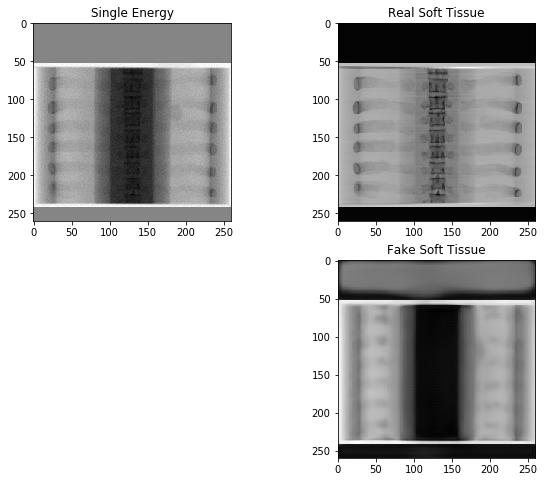

In [301]:
name = '0_0_0.npy'
idx = SE_names.index(name)
with torch.no_grad():
    val_data = torch.unsqueeze(dual_energy_dataset[idx], 0)
#     val_data = torch.unsqueeze(val_dataset[idx], 0)
    
    single_energy = torch.unsqueeze(val_data[:, 0, :, :], 1)
    fake_data = generator_model(single_energy.float().to(device))

    single_energy_sample = single_energy[0][0]
#     real_bone_sample = val_data[0, 1, :, :]
    real_soft_sample = val_data[0, 1, :, :]
#     fake_bone_sample = fake_data[0][0]
    fake_soft_sample = fake_data[0][0]
    
    fig, ax = plt.subplots(2, 2, figsize=(10, 8))

    ax[0][0].imshow(single_energy_sample.cpu().detach().numpy(), cmap='gray')
    ax[0][0].set_title('Single Energy')
    
#     ax[0][1].imshow(real_bone_sample.cpu().detach().numpy(), cmap='gray')
#     ax[0][1].set_title('Real Bone')
    
    ax[0][1].imshow(real_soft_sample.cpu().detach().numpy(), cmap='gray')
    ax[0][1].set_title('Real Soft Tissue')
    
    ax[1][0].set_visible(False)
    
#     ax[1][1].imshow(fake_bone_sample.cpu().detach().numpy(), cmap='gray')
#     ax[1][1].set_title('Fake Bone')
    
    ax[1][1].imshow(fake_soft_sample.cpu().detach().numpy(), cmap='gray')
    ax[1][1].set_title('Fake Soft Tissue')

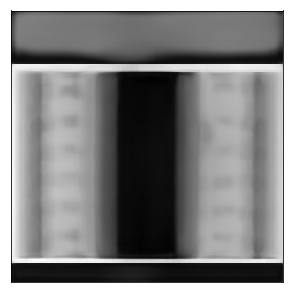

In [303]:
# fake_soft_sample = fake_soft_sample.cpu().detach().numpy()
plt.figure(figsize=(5,5))
plt.imshow(fake_soft_sample, cmap='gray')#, vmin=0, vmax=1.5)
plt.axes().get_xaxis().set_visible(False)
plt.axes().get_yaxis().set_visible(False)
plt.imsave(f'{name}_soft_fake.png', fake_soft_sample, cmap='gray')#, vmin=0, vmax=1.5)

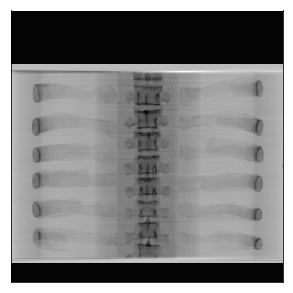

In [304]:
real_soft_sample = real_soft_sample.cpu().detach().numpy()
plt.figure(figsize=(5,5))
plt.imshow(real_soft_sample, cmap='gray')#, vmin=0, vmax=1.5)
plt.axes().get_xaxis().set_visible(False)
plt.axes().get_yaxis().set_visible(False)
plt.imsave(f'{name}_soft_real.png', real_soft_sample, cmap='gray')#, vmin=0, vmax=1.5)

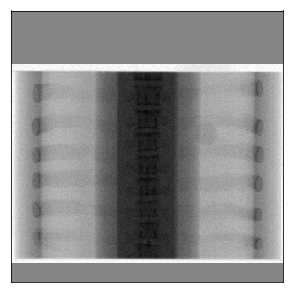

In [305]:
single_energy_sample = single_energy_sample.cpu().detach().numpy()
plt.figure(figsize=(5,5))
plt.imshow(single_energy_sample, cmap='gray')
plt.axes().get_xaxis().set_visible(False)
plt.axes().get_yaxis().set_visible(False)
plt.imsave(f'{name}_single_energy.png', single_energy_sample, cmap='gray')

In [267]:
logs_path = '/home/manwatkarc/DualEnergy_Synthetic_Energy/src/evaluation/logs/03_Mar_22-16:36:18/pix2pix_bone_logs(03_Mar_22-16:36:18).json'
with open(logs_path, 'r') as f:
    train_loss_dict = json.load(f)

config_path = '/home/manwatkarc/DualEnergy_Synthetic_Energy/src/evaluation/logs/03_Mar_22-16:36:18/pix2pix_bone_config(03_Mar_22-16:36:18).json'
with open(config_path, 'r') as f:
    config_dict = json.load(f)
    

In [269]:
config_dict

{'learning_rate': 0.0001,
 'epochs': 700,
 'lambda_L1': 1000,
 'lambda_D': 2,
 'dataset_length': 900,
 'img_size': 178}

In [270]:
len(train_loss_dict['L1'])

68544

In [313]:
def smoothing(lst, window=None):
    if window is None:
        window = len(lst) // 20
    smooth_lst = [sum(lst[i:i+window])/len(lst[i:i+window]) for i in range(0, len(lst), window)]
    return smooth_lst

train_losses_soft = train_loss_dict.copy()
w = config_dict['dataset_length'] // 8
for k, v in train_loss_dict.items():
    train_losses_soft[k] = smoothing(v, window=5*w)

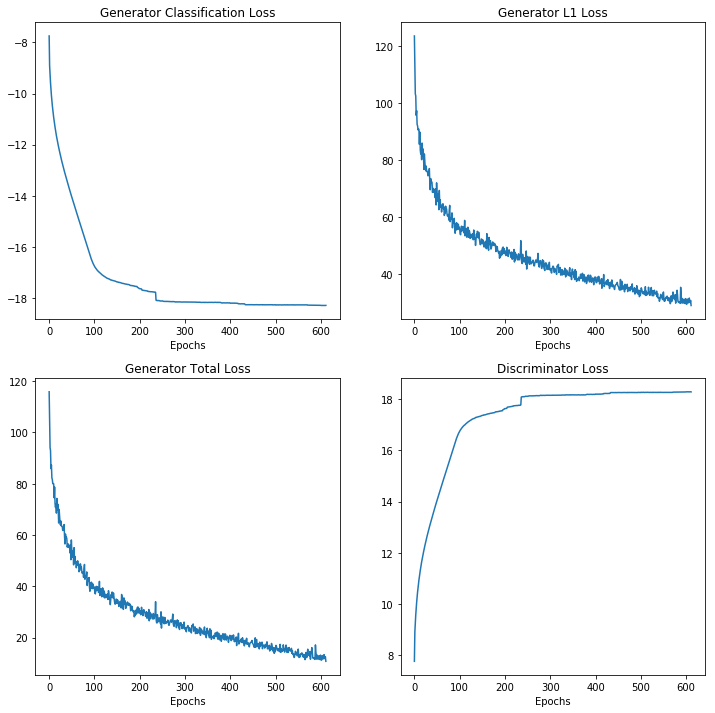

In [273]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax[0][0].plot(train_losses_soft['Generator']);
ax[0][0].set_title('Generator Classification Loss');
ax[0][0].set_xlabel('Epochs');

ax[0][1].plot(train_losses_soft['L1']);
ax[0][1].set_title('Generator L1 Loss');
ax[0][1].set_xlabel('Epochs');

generator_combined = [L1 + Lc for L1, Lc in 
                      zip(train_losses_soft['Generator'],
                          train_losses_soft['L1'])]

ax[1][0].plot(generator_combined);
ax[1][0].set_title('Generator Total Loss');
ax[1][0].set_xlabel('Epochs');

ax[1][1].plot(train_losses_soft['Discriminator']);
ax[1][1].set_title('Discriminator Loss');
ax[1][1].set_xlabel('Epochs');

Text(0,0.5,'SSIM')

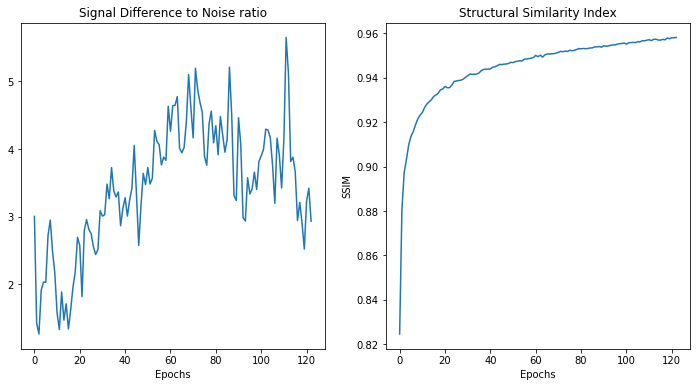

In [210]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
# ax[0].plot(train_loss_dict['SDNR'])
ax[0].plot(train_losses_soft['SDNR'])
ax[0].set_title('Signal Difference to Noise ratio')
ax[0].set_xlabel('Epochs')
ax[1].set_ylabel('SDNR')

# ax[1].plot(train_loss_dict['SSIM'])
ax[1].plot(train_losses_soft['SSIM'])
ax[1].set_title('Structural Similarity Index')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('SSIM')

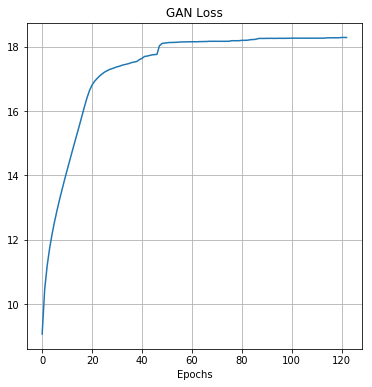

In [220]:
plt.figure(figsize=(6,6))
plt.plot([-1*i for i in train_losses_soft['Generator']]);
plt.title('GAN Loss');
plt.xlabel('Epochs');
plt.grid()
plt.savefig('Gen_GAN_loss.png')

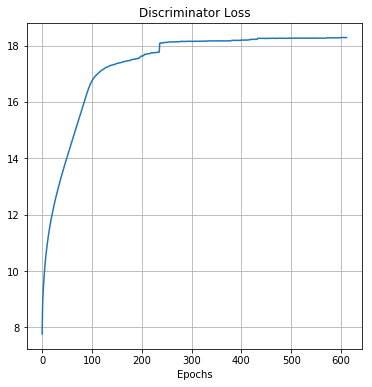

In [274]:
plt.figure(figsize=(6,6))
plt.plot(train_losses_soft['Discriminator']);
plt.title('Discriminator Loss');
plt.xlabel('Epochs');
plt.grid()
plt.savefig('Discriminator_loss.png')

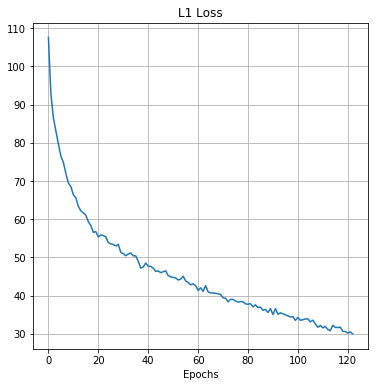

In [218]:
plt.figure(figsize=(6,6))
plt.plot(train_losses_soft['L1']);
plt.title('L1 Loss');
plt.xlabel('Epochs');
plt.grid()
plt.savefig('L1_loss.png')

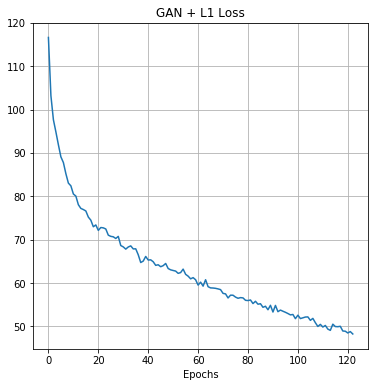

In [221]:
generator_combined = [L1 - Lg for Lg, L1 in 
                      zip(train_losses_soft['Generator'],
                          train_losses_soft['L1'])]


plt.figure(figsize=(6,6))
plt.plot(generator_combined);
plt.title('GAN + L1 Loss');
plt.xlabel('Epochs');
plt.grid()
plt.savefig('L1_GAN_loss.png')

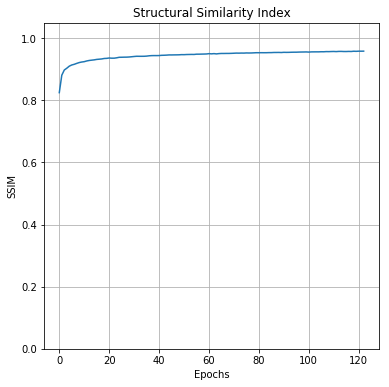

In [315]:
plt.figure(figsize=(6,6))
plt.plot(train_losses_soft['SSIM']);
plt.title('Structural Similarity Index');
plt.xlabel('Epochs');
plt.ylabel('SSIM')
plt.ylim([0, 1.05])
plt.grid()
plt.savefig('SSIM1.png')

In [318]:
L = len(train_losses_soft['SDNR'])

In [327]:
lst = range(0, L)
max([6*l for l in lst])

732

In [328]:
x_ticks = [6*l for l in lst]

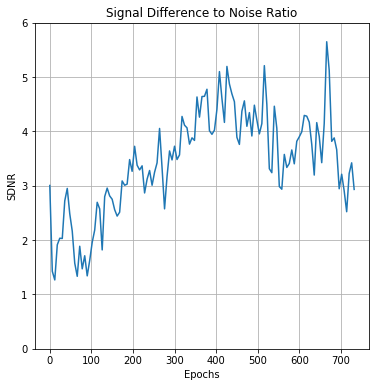

In [330]:
plt.figure(figsize=(6,6))
plt.plot(x_ticks, train_losses_soft['SDNR']);
plt.title('Signal Difference to Noise Ratio');
plt.xlabel('Epochs');
plt.ylabel('SDNR')
plt.ylim([0, 6])
plt.grid()
plt.savefig('SDNR.png')

In [228]:
generator_model.eval();

In [256]:
val_loader = DataLoader(dataset=dual_energy_dataset,
                          batch_size=4, shuffle=True)

In [231]:
classification_loss = nn.BCEWithLogitsLoss()
L1_loss = nn.L1Loss()

In [233]:
from skimage import metrics
def get_ssim(real, fake):
    if isinstance(fake, torch.Tensor):
        fake = fake.cpu().detach().numpy()
    if isinstance(real, torch.Tensor):
        real = real.cpu().detach().numpy()

    real = real[:, 0, :, :]    
    fake = fake[:, 0, :, :]
    return metrics.structural_similarity(real, fake, channel_axis=0)

In [234]:
class NLayerDiscriminator(nn.Module):
    """
    This class was inspired from 
    https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/
    Defines a PatchGAN discriminator
    """

    def __init__(self, input_nc, ndf=64, n_layers=4):
        """Construct a PatchGAN discriminator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            ndf (int)       -- the number of filters in the last conv layer
            n_layers (int)  -- the number of conv layers in the discriminator
            norm_layer      -- normalization layer
        """
        super().__init__()

        f_size = 4
        padding = 1
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=f_size,
                              stride=2, padding=padding),
                    nn.LeakyReLU(0.2, True)]
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = 2 ** n
            sequence += [nn.Conv2d(ndf * nf_mult_prev,
                                   ndf * nf_mult,
                                   kernel_size=f_size,
                                   stride=2,
                                   padding=padding),
                         nn.BatchNorm2d(ndf * nf_mult),
                         nn.LeakyReLU(0.2, True)]

        nf_mult_prev = nf_mult
        nf_mult = 2 ** n_layers
        sequence += [nn.Conv2d(ndf * nf_mult_prev,
                               ndf * nf_mult,
                               kernel_size=f_size,
                               stride=1, padding=padding),
                     nn.BatchNorm2d(ndf * nf_mult),
                     nn.LeakyReLU(0.2, True)]

        sequence += [nn.Conv2d(ndf * nf_mult,
                               1, kernel_size=f_size,
                               stride=1, padding=padding)]  # output 1 channel prediction map
        
        self.model = nn.Sequential(*sequence)

    def forward(self, x):
        return self.model(x)

In [235]:
discriminator_model = NLayerDiscriminator(input_nc=2, n_layers=4).to(device)

In [257]:
lambda_L1 = 1000
lambda_discriminator = 2
classification_loss = nn.BCEWithLogitsLoss()
L1_loss = nn.L1Loss()
# train_loss_dict = {'Generator':[], 'L1':[], 'Discriminator':[], 'SDNR':[], 'SSIM':[]}
val_loss_dict = {'Generator':[], 'L1':[], 'Discriminator':[], 'SSIM':[]}

def val_metrics_gen(preds, dual_energy, fake_dual_energy):
    labels = torch.zeros_like(preds).to(device)
    # Generator walks in the opposite direction of discriminator
    # Hence the -1 factor
    loss_c = -1 * classification_loss(preds, labels)
    loss_L1 = lambda_L1 * L1_loss(dual_energy, fake_dual_energy)
    loss = loss_c + loss_L1
    val_loss_dict['Generator'].append(loss_c.item())
    val_loss_dict['L1'].append(loss_L1.item())
    val_loss_dict['SSIM'].append(float(get_ssim(dual_energy, fake_dual_energy)))
    
def val_metrics_disc(prediction_real, prediction_fake):
    combined_preds = torch.cat((prediction_real, prediction_fake), 0)
    label_tensor = torch.cat((torch.ones_like(prediction_real),
                          torch.zeros_like(prediction_fake)),0)
    label_tensor = label_tensor.to(device)
    loss_c = lambda_discriminator * classification_loss(combined_preds, label_tensor)

    val_loss_dict['Discriminator'].append(loss_c.item())

In [258]:
for epoch in range(1):
    for batch_idx, val_batch in enumerate(val_loader):
        gc.collect()
        torch.cuda.empty_cache()

        real_data = val_batch.float().to(device)
        single_energy = torch.unsqueeze(real_data[:, 0, :, :], 1)
        dual_energy = real_data[:, 1:, :, :]

        fake_dual_energy = generator_model(single_energy)
        paired_fake = torch.cat((single_energy, fake_dual_energy), 1).float()
        
        prediction_fake = discriminator_model(paired_fake)
        prediction_real = discriminator_model(real_data)

        val_metrics_gen(prediction_fake.detach(), dual_energy, fake_dual_energy)
        val_metrics_disc(prediction_real, prediction_fake.detach())
        
#         if not batch_idx % 3:
#             print(f'Epoch {epoch:02d}, batch {batch_idx:04d}', end='\r')

In [259]:
for k, v in val_loss_dict.items():
    val_loss_dict[k] = np.array(v)

In [260]:
val_loss_dict

{'Generator': array([-0.81005484, -0.79081219, -0.80639142, -0.80491716, -0.81121826]),
 'L1': array([151.56983948, 220.09191895, 162.12043762,  76.58007812,
        277.84896851]),
 'Discriminator': array([1.43581986, 1.43539047, 1.43725073, 1.42707992, 1.43804622]),
 'SSIM': array([0.85791874, 0.82801354, 0.82878858, 0.90950501, 0.79347879])}

In [261]:
for k, v in val_loss_dict.items():
    print(k, np.mean(v), np.var(v))

Generator -0.8046787738800049 5.3387795559842744e-05
L1 177.64224853515626 4595.524132263717
Discriminator 1.4347174406051635 1.5499683231610108e-05
SSIM 0.8435409307479859 0.0015045862216490492
